<a href="https://colab.research.google.com/github/shivanishimpi/MRCNN_GDXray/blob/master/GDXray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Mounting GDrive

In [0]:
import os
from google.colab import drive
os.chdir('/content')
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pwd
!ls 'gdrive/'

/content
assets	  LICENSE      mask_rcnn_coco.h5  requirements.txt  setup.py
datasets  logs	       mrcnn		  samples
images	  MANIFEST.in  README.md	  setup.cfg


In [0]:
import os
#Change working directory to Mask R CNN
os.chdir('gdrive/My Drive/EAC:DNA:Xray/Mask-R-CNN-master')
#Print working directory to confirm
print(os.getcwd())

/content/gdrive/Shared drives/EAC:DNA:Xray/Mask-R-CNN-master


In [0]:
!ls 'samples/gdxray'

GDXrayColab.ipynb  inspect_data.ipynb	__pycache__
gdxray.py	   inspect_model.ipynb


In [0]:
#Excuse the error since it is imported in next cell
!python3 'samples/gdxray/gdxray.py' train --dataset='datasets/gdxray' --weights=coco

Traceback (most recent call last):
  File "samples/gdxray/gdxray.py", line 38, in <module>
    from mrcnn.config import Config
ModuleNotFoundError: No module named 'mrcnn'


##Library imports 

In [0]:
#Imports
import time
import os
import sys
import json
import random
import re
import datetime
import numpy as np
import skimage.draw
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath('./')

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log
import tensorflow as tf
import cv2
from skimage.measure import find_contours
import skimage
from skimage.measure import compare_ssim as ssim

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
GDXRAY_WEIGHTS_PATH = "//mask_rcnn_gdxray.h5"  

Using TensorFlow backend.


##Configuration

In [0]:

############################################################
#  Configurations
############################################################

############################################################
#  A new config class must be created that derives from the base Config class 
#  Config settings will be modified within this new class instead of the base config class
############################################################
class GDXrayConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "gdxray"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 + 1 + 1 # Background + shuriken + gun + key

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9


############################################################
#  Dataset
############################################################

############################################################
#  A new dataset class must be created that derives from the base Dataset class
#  This is how we control the loading of image and annotation data
#  must override load_mask and image_reference functions
#  The load_dset function is where we customize how we load our custom dataset
############################################################
class GDXrayDataset(utils.Dataset):

    def load_dset(self, dataset_dir, subset):
        """Load a subset of the GDXray dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only two classes to add.
        self.add_class("shuriken", 1, "shuriken")
        self.add_class("gun", 2, "gun")
        self.add_class("key", 3, "key")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        #Iterate through our annotations, fetching image meta data
        for mask_file in os.listdir(dataset_dir):
            if(mask_file.endswith('.json')):
                mask_path = os.path.join(dataset_dir, mask_file)
                annotations = json.load(open(mask_path))
                annotations = list(annotations.values())
                for a in annotations:
                    if len(a['regions']) > 0:
                        if type(a['regions']) is dict:
                            polygons = [r['shape_attributes'] for r in a['regions'].values()]
                        else:
                            polygons = [r['shape_attributes'] for r in a['regions']]

                        #width = a['file_attributes']['width']
                        #height = a['file_attributes']['height']

                        # if width and height are not in annotation, load image and get height and width
                        image_path = os.path.join(dataset_dir, a['filename'])
                        image = skimage.io.imread(image_path)
                        height, width = image.shape[:2]

                        image_path = os.path.join(dataset_dir, a['filename'])

                        label = a['regions'][0]['region_attributes']['Item']

                        self.add_image(label,
                            image_id=a['filename'],  # use file name as a unique image id
                            path=image_path,
                            width=width, height=height,
                            polygons=polygons)
            else:
                continue
        print(self.image_info)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a shurken or gun dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "shuriken" and image_info["source"] != "gun" and image_info["source"] != "key":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. 
        if image_info["source"] == "shuriken":
            #return array of ones
            return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
        elif image_info["source"] == "gun":
             return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32) + 1
        elif image_info["source"] == "key":
             return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32) + 2

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shuriken":
            return info["path"]
        elif info["source"] == "gun":
            return info["path"]
        elif info["source"] == "key":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = GDXrayDataset()
    dataset_train.load_dset(dataset, "train")
    dataset_train.prepare()

    #Temporarily use training as validation (to confirm running)
    # Validation dataset
    dataset_val = GDXrayDataset()
    dataset_val.load_dset(dataset, "train")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
               learning_rate=config.LEARNING_RATE,
               epochs=1,
               layers='heads')

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the noebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

def eval_model(model, inference_config, weights_path, DATASET_DIR):
    dataset = GDXrayDataset()
    #Temporarily load train instead of validation
    dataset.load_dset(DATASET_DIR, "train")
    dataset.prepare()

    #compute AP
    compute_ap_range(dataset, model, inference_config)

    #compute AP by itself
    compute_ap(dataset, model, inference_config)

def compute_ap(dataset, model, inference_config):
    image_ids = dataset.image_ids #np.random.choice(dataset.image_ids, 10)
    APs = []
    for image_id in image_ids:
        # Load image and ground truth data
        image_name = dataset.image_info[image_id]['id'] 
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, inference_config,image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        
        # Run detection
        results = model.detect([image], verbose=0)
        r = results[0]

        # Compute AP
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)

    print("mAP: ", np.mean(APs))

def compute_ap_range(dataset, model, inference_config):
    image_ids = dataset.image_ids #np.random.choice(dataset.image_ids, 10)
    APs = []
    for image_id in image_ids:
        # Load image and ground truth data
        image_name = dataset.image_info[image_id]['id'] 
        
        print(image_name + " ap range results:")
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, inference_config,image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        
        # Run detection
        results = model.detect([image], verbose=0)
        r = results[0]

        # Compute AP
        AP = utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    
    print("mAP Range: ", np.mean(APs))

##Training Module

In [0]:
############################################################
#  Training
############################################################

if __name__ == '__main__':
    isTrain = True
    weights = 'coco'
    dataset = './datasets/Key'
    logs = DEFAULT_LOGS_DIR
    """
    import argparse

    # Parse command line arguments
    parser = argparse.ArgumentParser(
        description='Train Mask R-CNN to detect shurikens.')
    parser.add_argument("command",
                        metavar="<command>",
                        help="'train' or 'detect'")
    parser.add_argument('--dataset', required=False,
                        metavar="/path/to/shuriken/dataset/",
                        help='Directory of the Shuriken dataset')
    parser.add_argument('--weights', required=True,
                        metavar="/path/to/weights.h5",
                        help="Path to weights .h5 file or 'coco'")
    parser.add_argument('--logs', required=False,
                        default=DEFAULT_LOGS_DIR,
                        metavar="/path/to/logs/",
                        help='Logs and checkpoints directory (default=logs/)')
    parser.add_argument('--image', required=False,
                        metavar="path or URL to image",
                        help='Image to apply the color splash effect on')
    parser.add_argument('--video', required=False,
                        metavar="path or URL to video",
                        help='Video to apply the color splash effect on')
    args = parser.parse_args()

    # Validate arguments
    if args.command == "train":
        assert args.dataset, "Argument --dataset is required for training"
    """

    print("Weights: ", weights)
    print("Dataset: ", dataset)
    print("Logs: ", logs)

    # Configurations
    if isTrain:
        config = GDXrayConfig()
    else:
        class InferenceConfig(GDXrayConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
        config = InferenceConfig()
    config.display()

    # Create model
    if isTrain:
        model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=logs)
    else:
        model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=logs)

    # Select weights file to load
    if weights.lower() == "coco":
        weights_path = COCO_WEIGHTS_PATH
        # Download weights file
        if not os.path.exists(weights_path):
            utils.download_trained_weights(weights_path)
    elif weights.lower() == "last":
        # Find last trained weights
        weights_path = model.find_last()
    elif weights.lower() == "imagenet":
        # Start from ImageNet trained weights
        weights_path = model.get_imagenet_weights()
    else:
        weights_path = weights

    # Load weights
    print("Loading weights ", weights_path)
    if weights.lower() == "coco":
        # Exclude the last layers because they require a matching
        # number of classes
        model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
    else:
        model.load_weights(weights_path, by_name=True)

Weights:  coco
Dataset:  ./datasets/Key
Logs:  /content/gdrive/Shared drives/EAC:DNA:Xray/Mask-R-CNN-master/logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_

In [0]:
    # Train or evaluate
    if isTrain:
        train(model)
    else:
        eval_model(model, config, weights_path,dataset)

[{'id': 'B0044_0001.png', 'source': 'key', 'path': './datasets/Key/train/B0044_0001.png', 'width': 2688, 'height': 2208, 'polygons': [{'name': 'polyline', 'all_points_x': [1047, 1001, 1014, 1005, 1017, 985, 1021, 1066, 1105, 1115, 1051], 'all_points_y': [1289, 1180, 1133, 1083, 1080, 917, 909, 1107, 1152, 1279, 1296]}]}, {'id': 'B0044_0002.png', 'source': 'key', 'path': './datasets/Key/train/B0044_0002.png', 'width': 2688, 'height': 2208, 'polygons': [{'name': 'polyline', 'all_points_x': [1040, 995, 1003, 991, 1007, 973, 1011, 1054, 1093, 1104, 1045], 'all_points_y': [1293, 1179, 1136, 1082, 1079, 913, 911, 1107, 1152, 1279, 1298]}]}, {'id': 'B0044_0003.png', 'source': 'key', 'path': './datasets/Key/train/B0044_0003.png', 'width': 2688, 'height': 2208, 'polygons': [{'name': 'polyline', 'all_points_x': [1023, 981, 990, 978, 991, 958, 997, 1037, 1073, 1086, 1028], 'all_points_y': [1293, 1186, 1131, 1081, 1079, 916, 911, 1106, 1149, 1278, 1298]}]}, {'id': 'B0044_0004.png', 'source': 'key'

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 1/1
100/100 [==============================] - 200s 2s/step - loss: 0.6758 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.1679 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.3243 - mrcnn_mask_loss: 0.1394 - val_loss: 0.5753 - val_rpn_class_loss: 0.0117 - val_rpn_bbox_loss: 0.1309 - val_mrcnn_class_loss: 0.0218 - val_mrcnn_bbox_loss: 0.2808 - val_mrcnn_mask_loss: 0.1302


In [0]:
!ls datasets/Key

imagesUsed.txt	key.json  train  val


In [0]:
    isTrain = False
    weights = 'last'
    # Configurations
    if isTrain:
        config = GDXrayConfig()
    else:
        class InferenceConfig(GDXrayConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
        config = InferenceConfig()
    config.display()

    # Create model
    if isTrain:
        model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=logs)
    else:
        model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=logs)

    # Select weights file to load
    if weights.lower() == "coco":
        weights_path = COCO_WEIGHTS_PATH
        # Download weights file
        if not os.path.exists(weights_path):
            utils.download_trained_weights(weights_path)
    elif weights.lower() == "last":
        # Find last trained weights
        weights_path = model.find_last()
    elif weights.lower() == "imagenet":
        # Start from ImageNet trained weights
        weights_path = model.get_imagenet_weights()
    else:
        weights_path = weights

    # Load weights
    print("Loading weights ", weights_path)
    if weights.lower() == "coco":
        # Exclude the last layers because they require a matching
        # number of classes
        model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
    else:
        model.load_weights(weights_path, by_name=True)
    # Train or evaluate
    if isTrain:
        train(model)
    else:
        eval_model(model, config, weights_path,dataset)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
def resize_image(image, min_dim=None, max_dim=None, min_scale=None, mode="square"):
    """Resizes an image keeping the aspect ratio unchanged.

    min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    min_scale: if provided, ensure that the image is scaled up by at least
        this percent even if min_dim doesn't require it.
    mode: Resizing mode.
        none: No resizing. Return the image unchanged.
        square: Resize and pad with zeros to get a square image
            of size [max_dim, max_dim].
        pad64: Pads width and height with zeros to make them multiples of 64.
               If min_dim or min_scale are provided, it scales the image up
               before padding. max_dim is ignored in this mode.
               The multiple of 64 is needed to ensure smooth scaling of feature
               maps up and down the 6 levels of the FPN pyramid (2**6=64).
        crop: Picks random crops from the image. First, scales the image based
              on min_dim and min_scale, then picks a random crop of
              size min_dim x min_dim. Can be used in training only.
              max_dim is not used in this mode.

    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might
        be inserted in the returned image. If so, this window is the
        coordinates of the image part of the full image (excluding
        the padding). The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """
    # Keep track of image dtype and return results in the same dtype
    image_dtype = image.dtype
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(0, 0), (0, 0)]
    crop = None

    if mode == "none":
        return image, window, scale, padding, crop

    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))
    if min_scale and scale < min_scale:
        scale = min_scale

    # Does it exceed max dim?
    if max_dim and mode == "square":
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max

    # Resize image using bilinear interpolation
    if scale != 1:
        image = utils.resize(image, (round(h * scale), round(w * scale)),
                       preserve_range=True)

    # Need padding or cropping?
    if mode == "square":
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "pad64":
        h, w = image.shape[:2]
        # Both sides must be divisible by 64
        assert min_dim % 64 == 0, "Minimum dimension must be a multiple of 64"
        # Height
        if h % 64 > 0:
            max_h = h - (h % 64) + 64
            top_pad = (max_h - h) // 2
            bottom_pad = max_h - h - top_pad
        else:
            top_pad = bottom_pad = 0
        # Width
        if w % 64 > 0:
            max_w = w - (w % 64) + 64
            left_pad = (max_w - w) // 2
            right_pad = max_w - w - left_pad
        else:
            left_pad = right_pad = 0
        padding = [(top_pad, bottom_pad), (left_pad, right_pad)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "crop":
        # Pick a random crop
        h, w = image.shape[:2]
        y = random.randint(0, (h - min_dim))
        x = random.randint(0, (w - min_dim))
        crop = (y, x, min_dim, min_dim)
        image = image[y:y + min_dim, x:x + min_dim]
        window = (min_dim, min_dim)
    else:
        raise Exception("Mode {} not supported".format(mode))
    return image.astype(image_dtype), window, scale, padding, crop

In [0]:
def mold_inputs(model, images):
        """Takes a list of images and modifies them to the format expected
        as an input to the neural network.
        images: List of image matrices [height,width,depth]. Images can have
            different sizes.

        Returns 3 Numpy matrices:
        molded_images: [N, h, w, 3]. Images resized and normalized.
        image_metas: [N, length of meta data]. Details about each image.
        windows: [N, (y1, x1, y2, x2)]. The portion of the image that has the
            original image (padding excluded).
        """
        molded_images = []
        image_metas = []
        windows = []
        for image in images:
            # Resize image
            # TODO: move resizing to mold_image()
            molded_image, window, scale, padding, crop = resize_image(
                image,
                min_dim=model.config.IMAGE_MIN_DIM,
                min_scale=model.config.IMAGE_MIN_SCALE,
                max_dim=model.config.IMAGE_MAX_DIM,
                mode=model.config.IMAGE_RESIZE_MODE)
            molded_image = modellib.mold_image(molded_image, model.config)
            # Build image_meta
            image_meta = modellib.compose_image_meta(
                0, image.shape, molded_image.shape, window, scale,
                np.zeros([model.config.NUM_CLASSES], dtype=np.int32))
            # Append
            molded_images.append(molded_image)
            windows.append(window)
            image_metas.append(image_meta)
        # Pack into arrays
        molded_images = np.stack(molded_images)
        image_metas = np.stack(image_metas)
        windows = np.stack(windows)
        return molded_images, image_metas, windows
      
def detect(model, images, verbose=0):
        """Runs the detection pipeline.

        images: List of images, potentially of different sizes.

        Returns a list of dicts, one dict per image. The dict contains:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [N] int class IDs
        scores: [N] float probability scores for the class IDs
        masks: [H, W, N] instance binary masks
        """
        assert model.mode == "inference", "Create model in inference mode."
        assert len(
            images) == model.config.BATCH_SIZE, "len(images) must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(images)))
            for image in images:
                log("image", image)

        # Mold inputs to format expected by the neural network
        molded_images, image_metas, windows = mold_inputs(model,images)

        # Validate image sizes
        # All images in a batch MUST be of the same size
        image_shape = molded_images[0].shape
        for g in molded_images[1:]:
            assert g.shape == image_shape,\
                "After resizing, all images must have the same size. Check IMAGE_RESIZE_MODE and image sizes."

        # Anchors
        anchors = model.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (model.config.BATCH_SIZE,) + anchors.shape)

        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("anchors", anchors)
        # Run object detection
        detections, _, _, mrcnn_mask, _, _, _ =\
            model.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(images):
            final_rois, final_class_ids, final_scores, final_masks =\
                model.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       windows[i])
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

[[[240 240 240]
  [240 240 240]
  [240 240 240]
  ...
  [245 245 245]
  [245 245 245]
  [245 245 245]]

 [[240 240 240]
  [240 240 240]
  [240 240 240]
  ...
  [245 245 245]
  [245 245 245]
  [245 245 245]]

 [[240 240 240]
  [240 240 240]
  [240 240 240]
  ...
  [245 245 245]
  [245 245 245]
  [245 245 245]]

 ...

 [[241 241 241]
  [241 241 241]
  [241 241 241]
  ...
  [245 245 245]
  [245 245 245]
  [244 244 244]]

 [[241 241 241]
  [241 241 241]
  [241 241 241]
  ...
  [246 246 246]
  [244 244 244]
  [244 244 244]]

 [[241 241 241]
  [241 241 241]
  [241 241 241]
  ...
  [246 246 246]
  [244 244 244]
  [243 243 243]]]
Processing 1 images
image                    shape: (2208, 2688, 3)       min:    2.00000  max:  250.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 2688.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.

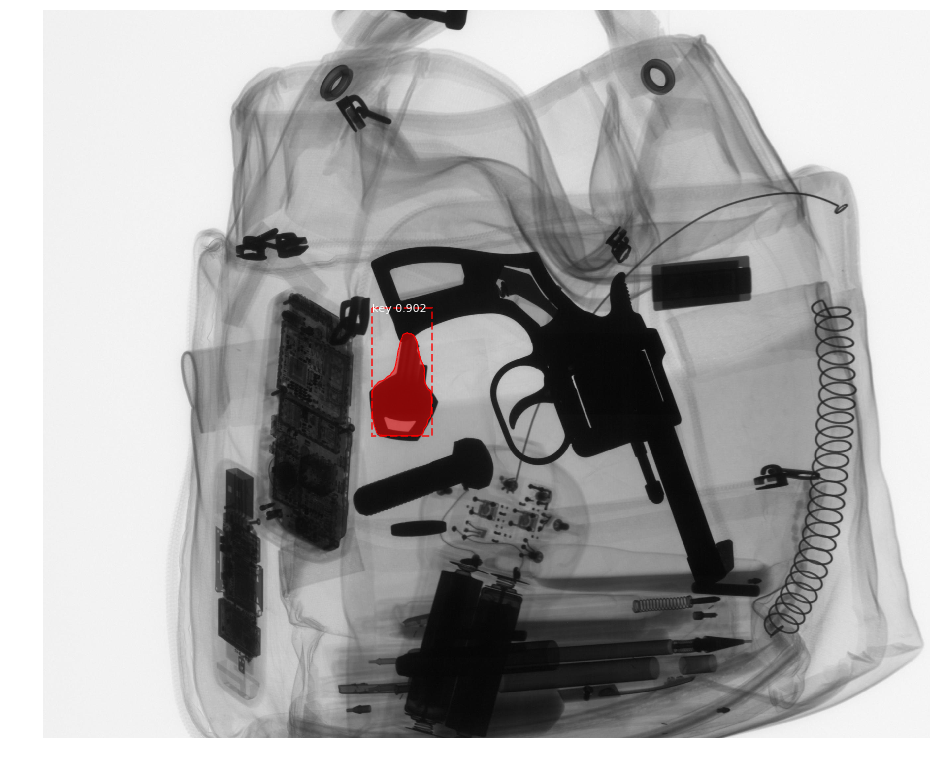

In [0]:
# Load a random image from the images folder
file_names = next(os.walk(dataset+"/train"))[2]
image = skimage.io.imread(os.path.join(dataset+"/train", random.choice(file_names)))

image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
print(image)

# Run detection
results = model.detect([image], verbose=1)

class_names = ['BG','shuriken','gun','key']

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])